In [20]:
import pandas as pd
import altair as alt
from IPython.display import Image

# Neah Bay Buoy Swell Report
The final project for DTSA 5304 is the development, evaluation and deployment of a visualization tool. My ambition is to visualize the character of oceanic swells seasonally on the west coast of Canada. My thought is that for businesses like hotels and surf schools, the tool could be implemented in order to assist potential customers to plan their holiday.

## Design Vision
The vision of the design is to have a plot anchored on a compass rose, with the direction of swell giving the angle on the compass and the radius of the segment being defined by the average swell size in some period of time. Similar plots are developed for wind conditions, such as this one:

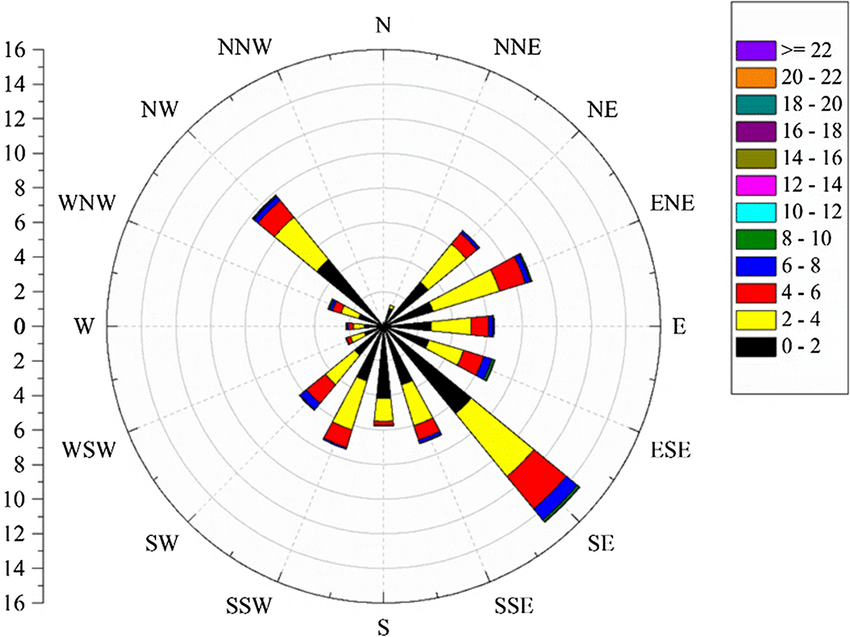

In [23]:
Image(filename='images\windrose.png') 

Rana, Madhvi & Mittal Cchem Frsc, Susheel & Beig, Gufran. (2021). Assessment and prediction of surface ozone in Northwest Indo-Gangetic Plains using ensemble approach. Environment, Development and Sustainability. 23. 10.1007/s10668-020-00841-8.

Multiple plots could be produced showing season swell characteristics, and then by using a slider the user could increase the granularity of the period, honing down on monthly and then weekly data. 

## Data Sources
The NOAA provides data for their oceanic buoys on their [National Buoy Database Center](https://www.ndbc.noaa.gov/). Of particular interest, living in Tofino, Canada, is the buoy at Neah Bay—the closest buoy providing directional wave data. The data headings are described on their page of [Measurement Descriptions and Units](https://www.ndbc.noaa.gov/measdes.shtml), however the most relevant data are the _date, significant wave height,_ and _dominant wave period direction_. Similar data is available for the very local [La Perouse Bank Buoy](https://www.ndbc.noaa.gov/station_page.php?station=46206), however that buoy does not collect spectral direction data. Similarly, the Amphritite Buoy collects quality data but is generally inaccessible. 

## Visualization Development
### Data exploration
Importing the Neah Bay data into Jupyter Lab we performed simple transformations and cleaning, producing extra columns for the date, the day and week of the year. The data was initially displayed in a simple scatter plot, showing the broad seasonal trends. 

In [2]:
swellData = pd.read_table('46087h2020.txt', skiprows = [1,2], sep = ' ', skipinitialspace = True, parse_dates={'DATE': ['MM', 'DD','#YY']})
swellData = swellData.drop(['hh', 'mm', 'WDIR', 	'WSPD', 	'GST', 	'APD', 	'PRES', 	'ATMP', 	'WTMP', 	'DEWP', 	'VIS', 	'TIDE'], axis = 1)


In [25]:
#swellData = swellData[swellData.DATE >= '2012-01-01']

swellData = swellData.groupby(pd.Grouper(key='DATE', axis=0, 
                      freq='d')).mean().reset_index()
#swellData

In [4]:
swellData = swellData[(swellData.WVHT.notnull())]

In [5]:
alt.Chart(swellData).mark_point(color='red').encode(y="WVHT", x='DATE')

alt.Chart(...)

In [6]:
swellData['DAY'] = swellData['DATE'].dt.dayofyear
swellData['WEEK'] = swellData['DATE'].dt.isocalendar().week
swellData['MONTH'] = swellData['DATE'].dt.month
swellData['SEASON'] = swellData.apply(lambda row : int(row['MONTH']/3), axis = 1)

Expectation was of an increase in swell height in the winter months, which is visually confirmed in the scatter plot. Interestingly, there are major outliers of very large swell in the early months of the year. These could be of interest to more skilled surfers looking for big waves, although local knowledge of particular breaks becomes important on this point.

A similar plot showing mean wave direction is less informative, as almost all points seem to lie in a 50 degree band. It is interesting to see some small trends, such as just after day 100, showing a total lack of swell from the 280° zone. 

In [7]:
dirScatter = alt.Chart(swellData).mark_point().encode(x = 'DAY', y = alt.Y("MWD", scale=alt.Scale(domain = [150,300])))
dirScatter

alt.Chart(...)

### Windrose development

The initial implementation of the "compass rose" design ran into some complications, where it was understood that the ```Theta``` command defines the angle subtended by the the data.

After several hours of exploration and investigation, it was discovered that Altair does not support a stacked polar histogram-type plot, which is foundationally what a windrose is. There is [extensive discussion on the Altair github](https://github.com/vega/vega-lite/issues/408) regarding the implementation of functionality allowing for this type of plot, but it does not appear to have been implemented as of yet. 

Considerable effort went into data manipulation such that an effective windrose could be developed, however the barriers imposed by the library combined with the lack of familiarity of the authors meant that the time commitment to produce the original product was too large for the scope of the project.

In [8]:
compassRose = alt.Chart(swellData).encode(
    theta=alt.Theta("MWD", stack=False),
    radius=alt.Radius("WVHT", scale=alt.Scale(type="sqrt")),
    color="MONTH:O"
)

compassRose.mark_arc(innerRadius=10, opacity = 0.3, stroke = '#123')

alt.Chart(...)

In [26]:
swellData['DIR'] = swellData.apply(lambda row : int(row['MWD']/16), axis = 1)
#swellData

In [27]:
#round(swellData['DIR'].max())

In [11]:
compassRose = alt.Chart(swellData).encode(
    theta=alt.Theta("DIR:O", stack=True),
    radius=alt.Radius("WVHT"),#, scale=alt.Scale(type="sqrt")),
    color="DIR:N"
)

compassRose.mark_arc(innerRadius=10, stroke = '#fff')

alt.Chart(...)

In [28]:
monthlySwell = swellData.groupby(swellData['MONTH']).mean().reset_index()
weeklySwell = swellData.groupby(swellData['WEEK']).mean().reset_index()
monthlySwell['DIR'] = monthlySwell.apply(lambda row : int(row['DIR']), axis = 1)
weeklySwell['DIR'] = weeklySwell.apply(lambda row : int(row['DIR']), axis = 1)
#monthlySwell

In [29]:
monthlySwell['MAX-WAVE'] = swellData.groupby(swellData['MONTH']).max().reset_index()['WVHT']
#monthlySwell

In [30]:
monthChart = alt.Chart(monthlySwell).mark_point().encode(
    alt.X("MONTH:O"),
    y='WVHT',
    color = 'DIR:O'
)

#monthChart

In [31]:
weekChart = alt.Chart(weeklySwell).mark_point().encode(
    x =alt.X("WEEK"),
    y='WVHT',
    color = 'DIR:N'
)

#weekChart

### Alternative visualisation designs

The ridgeline plot seems like something that could be highly effective in displaying wave data, even producing an appealing visual analogue to the ocean waves we're exploring. The production of the figure is not necessarily complicated, however a well-integrated form could be more time-intensive to produce than is viable for this project. I would suggest that this is an avenue for future exploration in subsequent iterations of the visualization design.

In [16]:
import altair as alt
from vega_datasets import data

source = swellData

step = 20
overlap = 1

alt.Chart(source, height=step).transform_timeunit(
    Month='month(DATE)'
).transform_joinaggregate(
    mean_temp='mean(WVHT)', groupby=['MONTH']
).transform_bin(
    ['bin_max', 'bin_min'], 'WVHT'
).transform_aggregate(
    value='count()', groupby=['MONTH', 'mean_temp', 'bin_min', 'bin_max']
).mark_area(
    interpolate='monotone',
    fillOpacity=0.6,
    stroke='lightgrey',
    strokeWidth=0.5
).encode(
    alt.X('bin_max:Q',  title='Daily maximum swell (m)', scale=alt.Scale(domain=[0,6])),
    alt.Y(
        'value:Q',
        scale=alt.Scale(range=[step, -step * overlap]),
        axis=None
    ),
    alt.Fill(
        'mean_temp:Q',
        #legend=None,
        scale=alt.Scale(domain=[1, 4], scheme='darkblue')
    )
).facet(
    row=alt.Row(
        'Month:T',
        title=None,
        header=alt.Header(labelAngle=0, labelAlign='right', format='%B')
    )
).properties(
    title='Neah Bay Swell',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_title(
    anchor='end'
)

alt.FacetChart(...)

## Final Design
In an effort to produce a functioning visualization for production, a simpler model of visualization was chosen. By recofusing on the core goals of the visualization, a combination of a date versus swell height scatter plot and histogram were produced. 

The ambition was initially to help surfers choose a time window for a trip to some surf region. The scatter plot above shows data points for each day recorded from our data set. The interactive nature of the scatter plot lets the user highlight the time window they are interested in visiting, and the histogram below shows the number of days with various swells in that period of interest. 

In [19]:
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['y'])
wavescale = alt.Color('DPD:N', scheme='darkblue')
# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_point(filled=True, opacity = 0.6, size=100).encode(
    alt.X('DATE:T', title='Date'),
    alt.Y('WVHT',
        title='Swell height (m)',
        scale=alt.Scale(domain=[0,6])
    ),
    color=alt.condition(brush, alt.value('darkblue'), alt.value('lightgray')),
).properties(
    width=600,
    height=400
).add_selection(
    brush
)


# Bottom panel is a bar chart of weather type
bars = alt.Chart().mark_bar(color='cyan').encode(
    x=alt.X('count()', title="Number of days at swell heights"),
    y=alt.Y(
        'WVHT:N', 
        bin=alt.Bin(maxbins=6),
        title="Swell height (m)",
    ),
).transform_filter(
    brush
).properties(
    width=600,
    height=100
)

alt.vconcat(
    points,
    bars,
    data=swellData,
    title="Swell Height at Neah Bay Buoy"
)

alt.VConcatChart(...)

## Evaluation
With a functioning visualization tool developed, the evaluation and iteration of the design can be pursued. Since the target user for the tool is non-specialists, and that there are specific goals for the functionality of the tool, user feedback is critical to the development and iteration process. Given that this tool is a prototype and not close to a deployment stage, an unstructured and wide-ranging evaluation technique like a journaling study, although providing unfiltered feedback, may be too vague to make directed progress in the development plan. As such, a semi-structured interview with a potential user is the preferred technique. We have decided that two separate types of interviews are necessary: the first with the consumer, the surfer, the tourist. This individual may have a wide range of subject and local knowledge, and as such the tool must be appropriate for the experienced surfer as well as a beginner. The second interview would be with the business owner on whose platform the tool will be deployed. This individual will have a vested interest in the tool being user friendly and _encouraging_ the customer to come to the community and use the business.  

The interview questions focus on a few main targets:
1. Do you know what this tool is useful for?
2. Do you think this tool would be helpful in planning a visit?
3. Based on your skill level, what time of year would you choose to visit a surf town with these conditions?
4. Would you take the feedback from the tool to help you decide when to visit this community?
5. Did this tool make you curious for more information about surf conditions?
6. Do you find the tool visually appealing to use?  Does it make you _want to go surfing_? 
7. Would you want to go to a business that offers this tool?

The feedback I received was mixed, as expected for an early prototype. 
From the customer side, I spoke to someone that has never surfed before but is interested in trying in the future. Primarily, their feedback was that they needed more guidance. They did understand that the tool was to tell them "when the surf was good", but what's good for some may not be good for all. The tool functioned well, but they had no context for the size of the swells. Is a 1m swell going to be frightening? What does a 4m swell look like on shore? The scatter plot was difficult to look at, with the large number of points making it confusing to decide what was important. The visualization was "technical" in appearance, and made it intimidating to make a decision on their own—exactly what the purpose is. Due to its spartan aesthetic, they also didn't feel encouraged to get out in the surf. 
Not all the feedback was critical, however. The user felt as though the business was serious, and the tool delivered an impression of rigour and knowledge. They also described the the tool as making them feel like the business _wanted them to succeed._ If they are helping you to decide when the surf is good for you, they are hoping that you can take advantage of the conditions. 

On the business side, less time was available for discussion, but primarily the concern was that the tool was too complex for novice surfers. If the tool were delivered in conjunction with a guide to wave heights or the tool itself gave a user skill rating or warning with various swell heights, they would be less concerned. The aesthetic was also too harsh for the surfing "vibe". In further development, significantly more feedback from the business side will be useful in gauging the "difficulty" level of the visualization. 

## Conclusions
The development of this tool was dramatically more complicated than expected. Coming up with an effective way of synthesizing all of the pertinent information in a single figure is challenging on its own, even before implementing interactivity or a relevant and appealing aesthetic. Considering the competence of the user and the obstacles to interpretability are also difficult to predict. As the authour or designer of a document or visualization, you have an inherent advantage over the audience on the subject.

The tool that was developed was ultimately rudimentary, but was effective enough in delivering the fundamentals or spirit of the task. The primary challenges are involved in providing user guidance. More information has to be provided to the user—thresholds, expectations, variability. These can be implemented in dynamic visual channels, but each additional informational channel adds a layer of complexity for the developer to integrate. Each aspect of the tool should be considered carefully before being added.

Additionally, improving the aesthetics is needed before any launch. As the developer has a technical background, it is easy to forget that plots and graphs can be intimidating to someone without that experience. Making such a tool appealing and fun to use is critical for user buy-in. 

In future iterations several key changes would be good to bring in:
1. Clustering and colour-mapping.
	By clustering the data points in the scatter plot, the visual "noise" would be reduced, which would make the experience less confronting for the user. If the data is clustered, a colour mapping could be then used to denote wave intensity or data point density. Colour variation could also be beneficial in improving the "vibe" of the tool—surfing should be fun!
2. Guidance
	In the histogram, using a colour scale to indicate skill-level similar to the rating system at ski hills could be an ideal method for communicating the threshold swell heights for an individual. These levels would be set with guidance from the businesses, which are the subject experts in the development process.
3. Bi-directional selection
	If a surfer understands what level they are comfortable with, they may be interested in only seeing swell days in a certain range. By allowing the user to select only days which are "blue squares" or "black diamonds", they would be able to again reduce the "noise" in their visualization. 